In [153]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

%matplotlib inline
# %pdb on

In [121]:
# Load dataset
alzheimer_dataset_path = "Datasets/10_alzheimers_disease_data.csv"
alz_df = pd.read_csv(alzheimer_dataset_path)

#The last column ('DoctorInCharge') contains same and no-relevant data for all patiens. let's remove it:
alz_df = alz_df.drop('DoctorInCharge', axis=1)
alz_df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,6.045039,0,0,0.014691,0,0,1,1,0,0


# Our Goals: #
- Understand to factors that influence the diagnosis
- Predict alzheimer desease

In [114]:
num_of_patients = alz_df.shape[0]
count_alzheimer = alz_df['Diagnosis'].value_counts()[1]
count_no_alzheimer = alz_df['Diagnosis'].value_counts()[0]
diagnosis_data = {
    'Diagnosis': ['Alzheimer', 'No Alzheimer'],
    'Count': [count_alzheimer, count_no_alzheimer]
}
diagnosis_df = pd.DataFrame(diagnosis_data)

First, let's "feel" the data by some infographics.

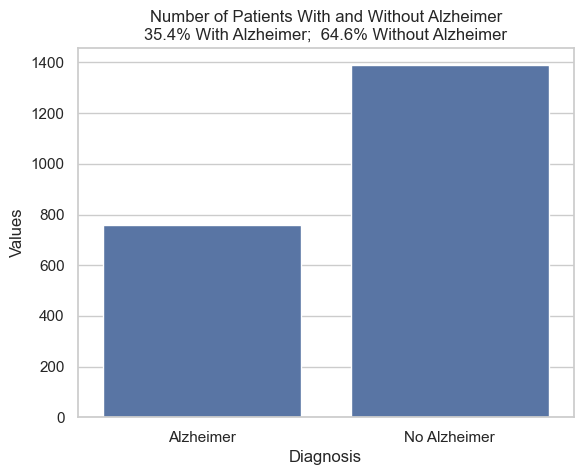

In [115]:
sns.set(style="whitegrid")
sns.barplot(x='Diagnosis', y='Count', data=diagnosis_df)
plt.title('Number of Patients With and Without Alzheimer\n'
          + str(round(100 * count_alzheimer / num_of_patients, 1)) + '% With Alzheimer'  + ';  ' + str(round(100 * count_no_alzheimer / num_of_patients, 1)) + '% Without Alzheimer')
plt.xlabel('Diagnosis')
plt.ylabel('Values')
plt.show()

**Explain**: In the dataset there are details of 1389 healthy patients, and only 760 diagnosed patients. The data in NOT close to be balanced, so we have to take it into account in case of training models.

For some binary features, let's try to figure out how they incluence about the diagnosis.<br>
We use the conditional probabilty formula: $ P(A|B) = P(A\cap B) / P(B) $.

In [171]:
def PlotCondProbSubplot(col_name, subplot_axes, feature_name, zero_feature_name, one_feature_name):
    count_zeros = alz_df[col_name].value_counts()[0]
    count_ones = alz_df[col_name].value_counts()[1]
    count_alz_zeros = ((alz_df[col_name] == 0) & (alz_df['Diagnosis'] == 1)).sum()
    count_alz_ones = ((alz_df[col_name] == 1) & (alz_df['Diagnosis'] == 1)).sum()

    subplot_data = {
        feature_name: [zero_feature_name, one_feature_name],
        'Prob': [count_alz_zeros / count_zeros, count_alz_ones / count_ones]
    }
    subplot_df = pd.DataFrame(subplot_data)

    sns.barplot(x=feature_name, y='Prob', data=subplot_df, ax=subplot_axes, width=0.4)
    subplot_axes.set_ylabel('Probability')
    subplot_axes.set_ylim([0, 1])

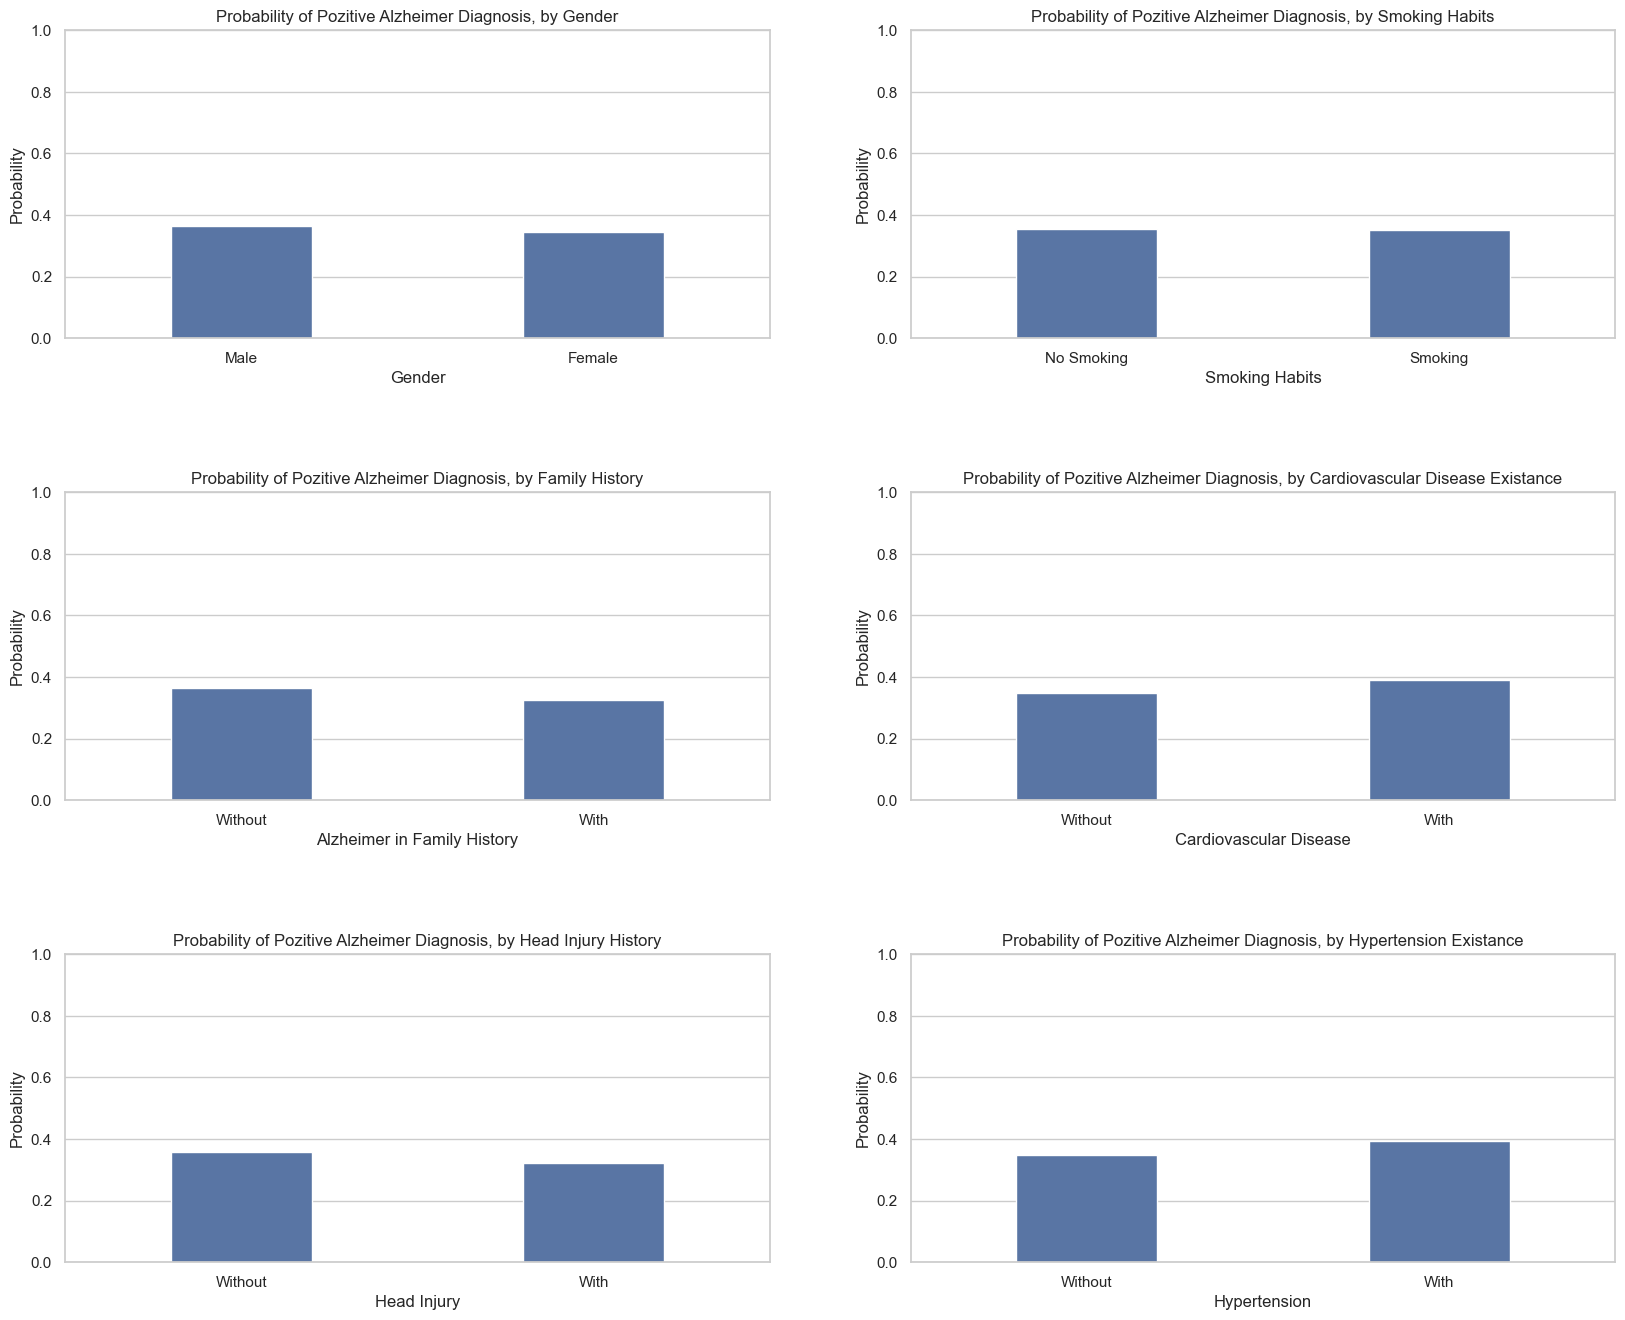

In [174]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16))
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.2)

PlotCondProbSubplot('Gender', axes[0, 0], 'Gender', 'Male', 'Female')
axes[0, 0].set_title('Probability of Pozitive Alzheimer Diagnosis, by Gender');

PlotCondProbSubplot('Smoking', axes[0, 1], 'Smoking Habits', 'No Smoking', 'Smoking')
axes[0, 1].set_title('Probability of Pozitive Alzheimer Diagnosis, by Smoking Habits');

PlotCondProbSubplot('FamilyHistoryAlzheimers', axes[1, 0], 'Alzheimer in Family History', 'Without', 'With')
axes[1, 0].set_title('Probability of Pozitive Alzheimer Diagnosis, by Family History');

PlotCondProbSubplot('CardiovascularDisease', axes[1, 1], 'Cardiovascular Disease', 'Without', 'With')
axes[1, 1].set_title('Probability of Pozitive Alzheimer Diagnosis, by Cardiovascular Disease Existance');

PlotCondProbSubplot('HeadInjury', axes[2, 0], 'Head Injury', 'Without', 'With')
axes[2, 0].set_title('Probability of Pozitive Alzheimer Diagnosis, by Head Injury History');

PlotCondProbSubplot('Hypertension', axes[2, 1], 'Hypertension', 'Without', 'With')
axes[2, 1].set_title('Probability of Pozitive Alzheimer Diagnosis, by Hypertension Existance');

**Explain:** It appears that no single binary characteristic definitively distinguishes Alzheimer’s patients.

In order to get a wide point of view about the relation between each feature and the diagnosis, let's calculate and look at the correlation matrix.<br>
While the covariance matrix measures the the direction of the joint linear relationship of two variables, The correlation matrix normalizes the covariance to provide both strength and direction of the relationship.<br>

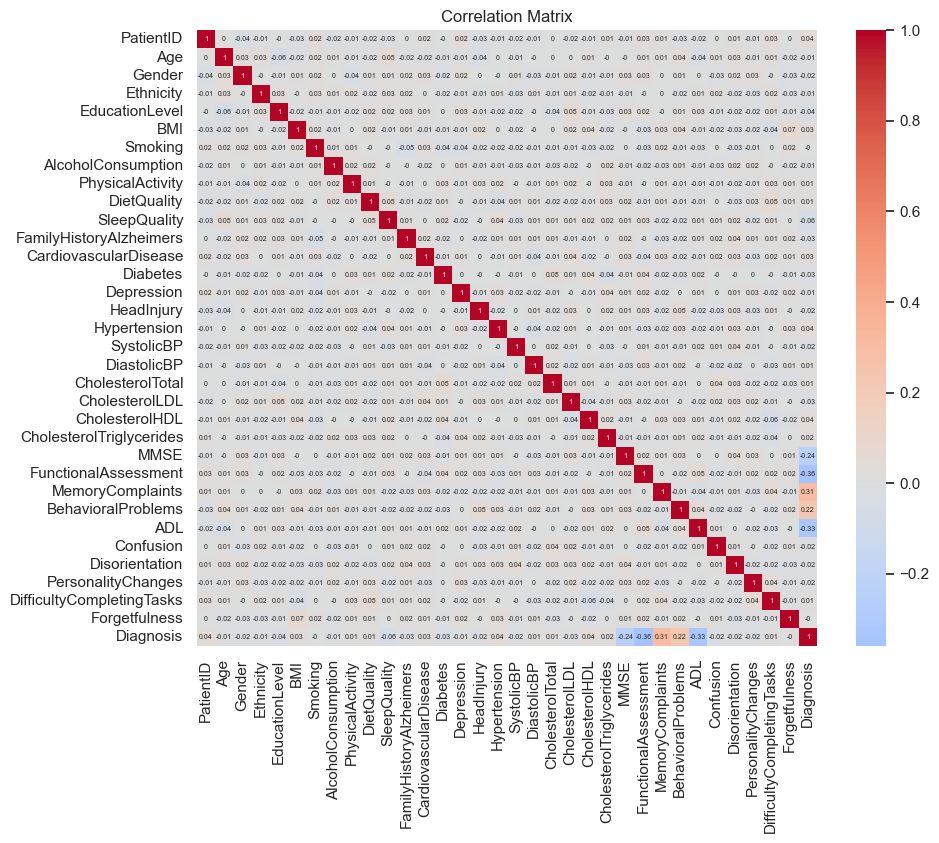

In [130]:
# Calculate correlation matrix
correlation_matrix = alz_df.corr()
correlation_matrix = round(correlation_matrix, 2)

# Get correlation with the label
diagnosis_correlation = correlation_matrix['Diagnosis'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 5})
plt.title('Correlation Matrix')
plt.show()

**Explain:** The last row (or column) in the matrix is the most that matters (represents the correlation between each feature and the 'Diagnosis' label). What we can see is that there are strong correlations between the following features and the diagnosis:
- MMSE (Mini-Mental State Examination)
- functional assessment
- memory complaints
- behavioral probles
- ADL (Activities of Daily Living score)

These results are neither surprising nor useful, as they highlight symptoms of Alzheimer’s rather than identifying characteristics that could cause it (like BMI, cholesterol values, etc.).

## Predictive Model and a Combination of Several Features for Prediction
We will eliminate the consequential factors from the DataFrame and construct a predictive model to better understand the relationships between the disease and its causes.

In [154]:
features_df = alz_df
features_df = features_df.drop(
    columns=['PatientID', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis'],
    axis=1)
labels = alz_df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

                     Feature  Importance
18          CholesterolTotal    0.077545
4                        BMI    0.076407
20            CholesterolHDL    0.076339
21  CholesterolTriglycerides    0.076131
7           PhysicalActivity    0.076119
19            CholesterolLDL    0.076088
6         AlcoholConsumption    0.076019
9               SleepQuality    0.075613
8                DietQuality    0.074387
16                SystolicBP    0.069361
17               DiastolicBP    0.064398
0                        Age    0.060944
3             EducationLevel    0.025204
2                  Ethnicity    0.021446
1                     Gender    0.011006
5                    Smoking    0.010046
13                Depression    0.010010
15              Hypertension    0.009915
10   FamilyHistoryAlzheimers    0.009342
12                  Diabetes    0.008763
11     CardiovascularDisease    0.008233
14                HeadInjury    0.006684


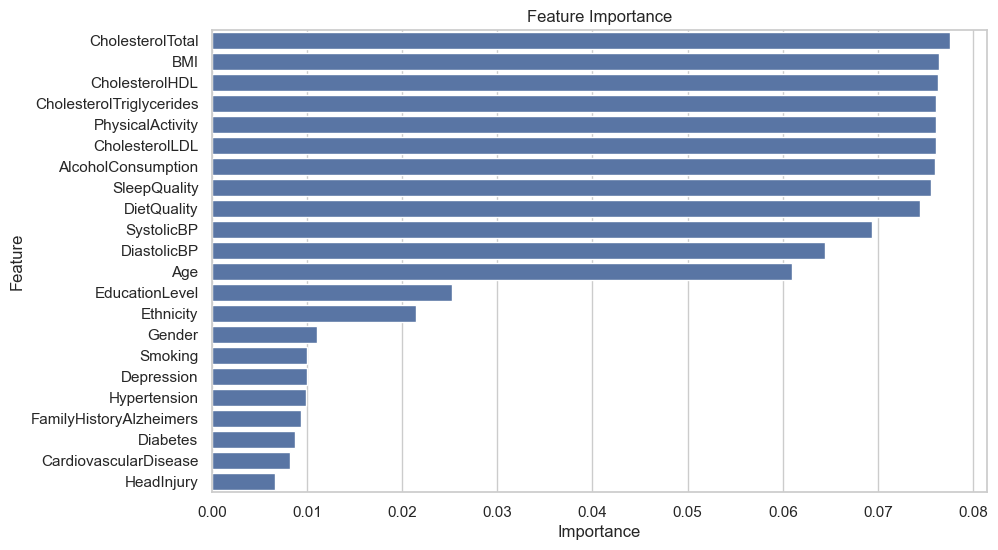

In [155]:
# Initialize the model
rf_model = RandomForestClassifier()

# Fit the model
rf_model.fit(X_train, y_train);

# Get feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features_df.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.64      0.95      0.77       277
           1       0.28      0.03      0.06       153

    accuracy                           0.63       430
   macro avg       0.46      0.49      0.41       430
weighted avg       0.51      0.63      0.51       430



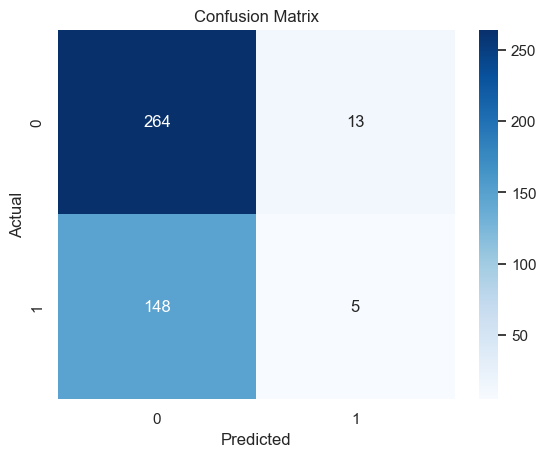

In [156]:
# Predictions
y_pred = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Precision, Recall, and F1-Score
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()